# ARTIFICIAL INTELLIGENCE & MACHINE LEARNING PROJECT WORK

As members of the data science team at a prestigious fast fashion firm, our job is to help increase revenues through all possible (legal) means. The online platform is going strong. However, we would like to improve the recommender system on our platform. Our plan is to test different recommendation systems and pick the most suitable one. Let's start.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Customer's Dataset EDA

In [2]:
# Let's start by analysing the customer's dataset: first of all we import it and then we print a small insight of the dataset: 
customers = pd.read_csv("recsys_customers.csv")
customers.head()

,customer_id,fashion_news,club_member,age
0,0,1,1,44.0
1,1,1,1,33.0
2,2,0,0,29.0
3,3,0,0,21.0
4,4,0,0,23.0


In [3]:
# Display dimension of the dataset
customers.shape

(41253, 4)

### Handling Null values

When performing EDA, a crucial role is played by NaN values. First of all let's see how many NaN are here.

In [4]:
customers.isnull().sum()

customer_id       0
fashion_news      0
club_member       0
age             133
dtype: int64

Now we can clearly see that the only column that contains null values is the "age" column. 
Given that, there are different ways to handle null values: 
1) Drop rows with missing data: if the percentage of missing values is relatively low, one option is to simply remove the rows that have missing values. This is a straightforward approach, but it can reduce the sample size and potentially bias the results if the missing data is not randomly distributed.
2) Impute missing values: another option is to impute the missing values, which means replacing the missing values with some estimated value, such as using the mean, median or mode of the non-missing values for that feature.

Since we don't want to reduce the sample size and eventually bias the results, we will follow the second approach.

In the case of a column with ages, we think that it is slightly better to use the mean or median of the non-missing values for that feature, rather than the mode. This is because the mean and median are measures of central tendency that are more sensitive to the majority of the values in the distribution, whereas the mode is more sensitive to the most common value(s), and might not accurately represent the overall distribution.


Let's plot the histogram of the age column.

Text(0, 0.5, 'Number of Customers')

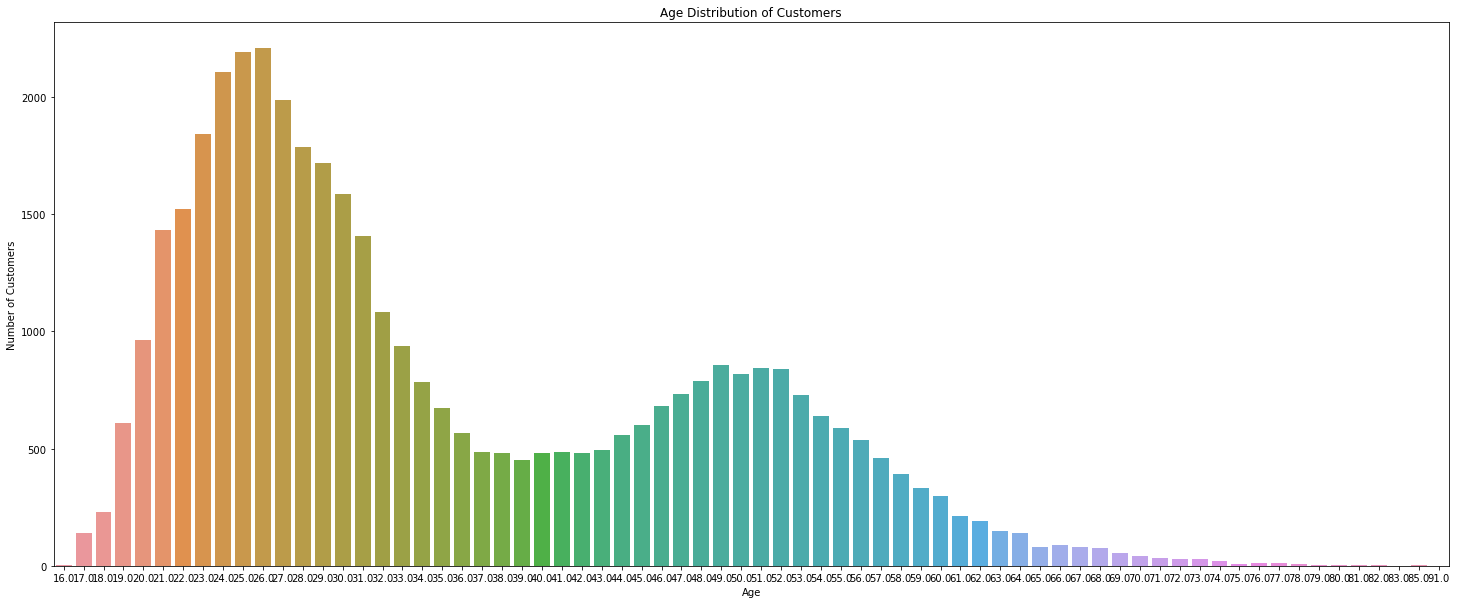

In [5]:
# Select the age column
age = customers['age']

# Plot the barplot
plt.figure(figsize=(25,10))
sns.countplot(x=age)

# Add a title and labels
plt.title("Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Number of Customers")


We can see that the histogram is not very symmetrical, but neither it has an highly skewed distribution. Furthermore, the missing values are numerical and there are very few of them. In addition, the mean is a good summary statistic that represents the central tendency of the data, and replacing the missing values with the mean can help preserve the statistical properties of the data. So let's proceed and replace the null values with the mean of the non-null values.




In [6]:
# Let's calculate the mean of the age column
mean_age = customers['age'].mean()

# Replace missing values with the mean
customers['age'] = customers['age'].fillna(mean_age)

print(customers)

       customer_id  fashion_news  club_member   age
0                0             1            1  44.0
1                1             1            1  33.0
2                2             0            0  29.0
3                3             0            0  21.0
4                4             0            0  23.0
...            ...           ...          ...   ...
41248        41248             1            1  33.0
41249        41249             0            0  25.0
41250        41250             1            1  20.0
41251        41251             1            1  29.0
41252        41252             0            0  24.0

[41253 rows x 4 columns]


In [7]:
print(mean_age)

35.32069552529183


We can point out that the mean is a float number, hence it can be a good idea to convert the values in the age column from float into integers.

In [8]:
customers['age'] = customers['age'].round().astype(int)
print(customers)

       customer_id  fashion_news  club_member  age
0                0             1            1   44
1                1             1            1   33
2                2             0            0   29
3                3             0            0   21
4                4             0            0   23
...            ...           ...          ...  ...
41248        41248             1            1   33
41249        41249             0            0   25
41250        41250             1            1   20
41251        41251             1            1   29
41252        41252             0            0   24

[41253 rows x 4 columns]


### Customers' Categorization

Our dataset gives us some insights on the customers. To be more precise, we have their id, their age, whether they are subscribed to the newsletter or not and whether they are members the special club or not.
Going into detail, we know that a customer who is subscribed to the newsletter corresponds to 1 in the fashion_news column, a customer who is not subscribed corresponds to 0. The same reasoning is applied with the club_member column.
Let's visualize it.

#### Newsletter Subscription Categorization

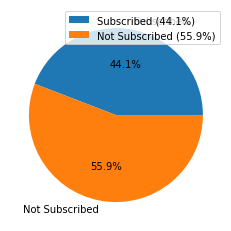

In [9]:
# Count the number of subscribed and not subscribed customers
subscribed = customers[customers['fashion_news'] == 1]['fashion_news'].count()
not_subscribed = customers[customers['fashion_news'] == 0]['fashion_news'].count()

# Calculate the percentage of subscribed and not subscribed customers
subscribed_percent = round(subscribed / (subscribed + not_subscribed) * 100, 1)
not_subscribed_percent = round(not_subscribed / (subscribed + not_subscribed) * 100, 1)

# Plot a pie chart of the fashion_news column
plt.pie([subscribed, not_subscribed], labels=['Subscribed', 'Not Subscribed'], autopct='%1.1f%%')
plt.legend(['Subscribed ({}%)'.format(subscribed_percent), 'Not Subscribed ({}%)'.format(not_subscribed_percent)])
plt.show()

#### Club Membership Categorization

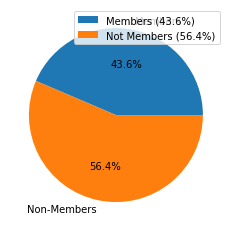

In [10]:
# Let's do the same for the special club members


# Count the number of club members and non-members
members = customers[customers['club_member'] == 1]['club_member'].count()
non_members = customers[customers['club_member'] == 0]['club_member'].count()

# Calculate the percentage of subscribed and not subscribed customers
members_percent = round(members / (members + non_members) * 100, 1)
non_members_percent = round(non_members / (members + non_members) * 100, 1)

# Plot a pie chart of the club_member column
plt.pie([members, non_members], labels=['Members', 'Non-Members'], autopct='%1.1f%%')
plt.legend(['Members ({}%)'.format(members_percent), 'Not Members ({}%)'.format(non_members_percent)])
plt.show()


The results are quite interesting...there seems to be a strict correlation between the members of the club (resp. non members) and the people subscribed (resp. not subscribed) to the newsletter.
To gain more insights about that, one of the most important measure to determine whether two variables are correlated and the strength of the correlation is the Pearson Correlation Coefficient. It is a measure of the strength and direction of the linear relationship between two variables. It is calculated as the covariance of the two variables divided by the product of their standard deviations. Let's run it and then interpret the results


              customer_id  fashion_news  club_member       age
customer_id      1.000000      0.005404     0.005145  0.002549
fashion_news     0.005404      1.000000     0.988353  0.063044
club_member      0.005145      0.988353     1.000000  0.065590
age              0.002549      0.063044     0.065590  1.000000


<AxesSubplot:>

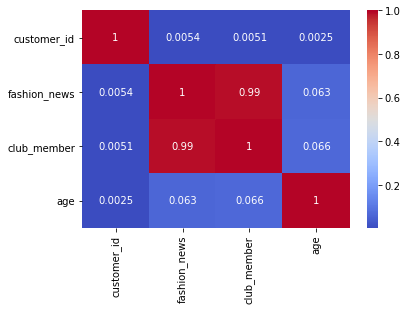

In [11]:
# Calculate the Pearson correlation between the columns
corr = customers.corr(method='pearson')

# View the correlation matrix
print(corr)

# Plot a fancier visualization (heatmap) of the correlations
sns.heatmap(corr, cmap='coolwarm', annot=True)

Before commenting the output, the following is a short explanation of the Pearson's coefficient:
- A coefficient of 1 indicates a strong positive correlation. This means that as one variable increases, the other variable also increases.
- A coefficient of -1 indicates a strong negative correlation. This means that as one variable increases, the other variable decreases.
- A coefficient between 0 and 1 (exclusive) indicates a weak positive correlation. This means that as one variable increases, the other variable increases, but not as strongly.
- A coefficient between -1 and 0 (exclusive) indicates a weak negative correlation. This means that as one variable increases, the other variable decreases, but not as strongly.


Given that, let's briefly comment the result. The matrix confirms our assumption: there is a very high correlation between the members of the club (resp. non members) and the people subscribed (resp. not subscribed) to the newsletter.
We can just ignore the upper row and the farmost-left column, since they take into accunt the customer's id (unique), which has clearly not any correlation with the rest of the information.


#### Age Group Categorization

Let's move now to the age column. 
It can be pretty useful to use the violin plot in order to visualize the distribution of the age values in our dataset.



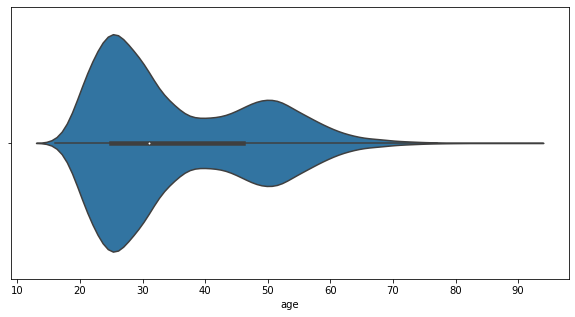

In [12]:
plt.figure(figsize=(10,5))
sns.violinplot(x='age', data=customers)
plt.show()

The small point in the center of the box is the median: the value below which 50% of the data falls. Let's compute this value.

In [13]:
median_age = customers['age'].median()
print(median_age)

31.0


We can categorize customers by their age, providing some ranges: young adults (16-24), adults (25, 44), middle-aged adults (45, 69), seniors (70+).

In [14]:

# create a function to categorize the age ranges
def categorize_age(age):
    if age < 39:
        return 'Young Adults'
    elif age < 50:
        return 'Early Middle-aged Adults' 
    elif age < 65:
        return 'Late Middle-aged Adults'
    else:
        return 'Seniors'



# apply the function to the age column and create a new column with the age ranges
customers['age_range'] = customers['age'].apply(categorize_age)

# view the dataframe with the new age_range column
print(customers)


       customer_id  fashion_news  club_member  age                 age_range
0                0             1            1   44  Early Middle-aged Adults
1                1             1            1   33              Young Adults
2                2             0            0   29              Young Adults
3                3             0            0   21              Young Adults
4                4             0            0   23              Young Adults
...            ...           ...          ...  ...                       ...
41248        41248             1            1   33              Young Adults
41249        41249             0            0   25              Young Adults
41250        41250             1            1   20              Young Adults
41251        41251             1            1   29              Young Adults
41252        41252             0            0   24              Young Adults

[41253 rows x 5 columns]


In [15]:
age_range_counts = customers.groupby('age_range').size()
age_range_counts

age_range
Early Middle-aged Adults     6613
Late Middle-aged Adults      7168
Seniors                       591
Young Adults                26881
dtype: int64

Let's see the age ranges and their percentage through a bar plot.

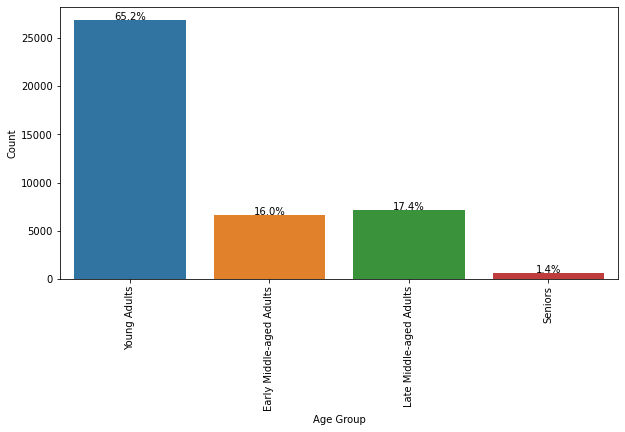

In [16]:
# Create a dataframe with the counts of customers in each age range
age_group_counts = customers['age_range'].value_counts().reset_index().rename(columns={'index': 'Age Group', 'age_range': 'Count'})


# Plot a bar plot of the age_range column
plt.figure(figsize=(10,5))
sns.barplot(x='Age Group', y='Count', data=age_group_counts, order=['Young Adults', 'Early Middle-aged Adults', 'Late Middle-aged Adults', 'Seniors'])

# Add the percentage values on top of the bar plot bars
for i, patch in enumerate(plt.gca().patches):
    height = patch.get_height()
    percentage = '{:.1f}%'.format(height / customers.shape[0] * 100)
    plt.gca().text(patch.get_x() + patch.get_width() / 2, height + 1, percentage, ha='center')

plt.xticks(rotation=90)
plt.show()

We can see that the vast majority of customers is in the 16-39 age range, which, according to us, even though is a pretty large range, reflects quite good society's trend. 

 

#### Newsletter Subscription/Age Categorization

Now that we have our customers' categorization by age, we can see how different groups are correlated with the subscription status (fashion_news) and club membership status (club_member).

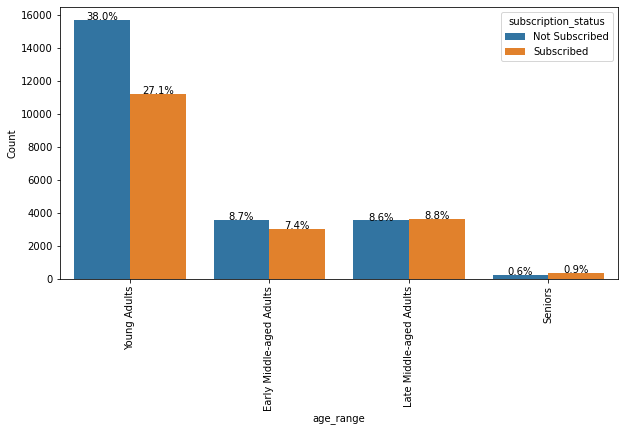

In [17]:
# Create a new column with the subscription status
customers['subscription_status'] = customers['fashion_news'].apply(lambda x: 'Subscribed' if x == 1 else 'Not Subscribed')

# Create a dataframe with the counts of customers in each age range and subscription status
age_subscription_counts = customers.groupby(['age_range', 'subscription_status'])['customer_id'].count().reset_index().rename(columns={'customer_id': 'Count'})

# Plot a bar plot of the age_range and subscription_status columns
plt.figure(figsize=(10,5))
sns.barplot(x='age_range', y='Count', hue='subscription_status', data=age_subscription_counts, order=['Young Adults', 'Early Middle-aged Adults', 'Late Middle-aged Adults', 'Seniors'])

# Add the percentage values on top of the bar plot bars
for i, patch in enumerate(plt.gca().patches):
    height = patch.get_height()
    percentage = '{:.1f}%'.format(height / customers.shape[0] * 100)
    plt.gca().text(patch.get_x() + patch.get_width() / 2, height + 1, percentage, ha='center')

plt.xticks(rotation=90)
plt.show()


#### Club Membership/Age Categorization

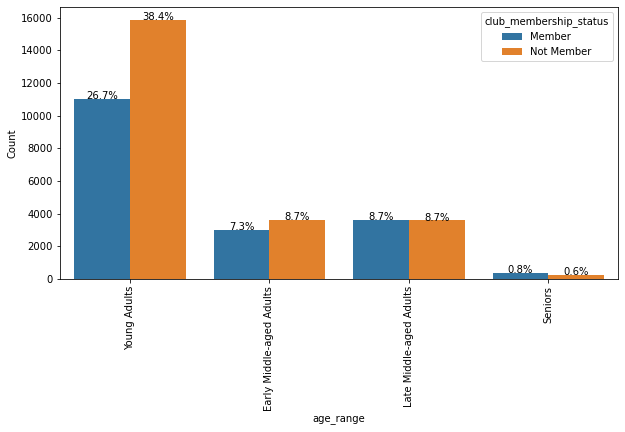

In [18]:
# Create a new column with the club membership status
customers['club_membership_status'] = customers['club_member'].apply(lambda x: 'Member' if x == 1 else 'Not Member')

# Create a dataframe with the counts of customers in each age range and club membership status
age_membership_counts = customers.groupby(['age_range', 'club_membership_status'])['customer_id'].count().reset_index().rename(columns={'customer_id': 'Count'})

#Pplot a bar plot of the age_range and club_membership_status columns
plt.figure(figsize=(10,5))
sns.barplot(x='age_range', y='Count', hue='club_membership_status', data=age_membership_counts, order=['Young Adults', 'Early Middle-aged Adults', 'Late Middle-aged Adults', 'Seniors'] )

# Add the percentage values on top of the bar plot bars
for i, patch in enumerate(plt.gca().patches):
    height = patch.get_height()
    percentage = '{:.1f}%'.format(height / customers.shape[0] * 100)
    plt.gca().text(patch.get_x() + patch.get_width() / 2, height + 1, percentage, ha='center')

plt.xticks(rotation=90)
plt.show()

All these visualizations help us to better understand our customers' information.

Now let's move to the second dataset which is really important: articles that our company sells. This dataset has a lot of information, such as the article name, product type, product group, product color and so on...let's go into details.

## Article's Dataset EDA

In [19]:
# Let's start by analysing the article's dataset: first of all we import it and then we print a small insight of the dataset: 

articles = pd.read_csv("recsys_articles.csv")
articles.head(10)

,article_id,prod_name,product_type,product_type_name,product_group_name,colour_group,colour_group_name,perceived_colour_value,perceived_colour_value_name,perceived_colour_master,...,department,department_name,index,index_name,index_group,index_group_name,section,section_name,garment_group,garment_group_name
0,0,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
1,1,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
2,2,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
3,3,200 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
4,4,Control Top 50 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
5,5,Black Umbrella,532,Umbrella,Items,9,Black,4,Dark,5,...,3419,Other items,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories
6,6,Dorian l/s basic,252,Sweater,Garment Upper body,73,Dark Blue,4,Dark,2,...,8559,Men Sport Woven,S,Sport,26,Sport,22,Men H&M Sport,1005,Jersey Fancy
7,7,Dorian l/s basic,252,Sweater,Garment Upper body,8,Dark Grey,4,Dark,12,...,8559,Men Sport Woven,S,Sport,26,Sport,22,Men H&M Sport,1005,Jersey Fancy
8,8,200 den 1p leggings,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
9,9,Nouvelle 1p Stay Up,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights


In [20]:
# Display dimension of the dataset
articles.shape

(6536, 21)

We notice that this dataset is more complex: it has 21 columns instead of just 4 (customer's dataset) and we may think that some of them are kinda duplicate and therefore usless, such that the columns product type or colour group, which are followed by a very similar column. But that's not the case and it is actually very useful, because when we deal with any categorical variables, we need to encode them as numerical values in order to use them in the recommendation system. 

### Handlind Null values

As we said before, when performing EDA, a crucial role is played by null values. Let's see how many nulls are there.

In [21]:
articles.isnull().sum()

article_id                      0
prod_name                       0
product_type                    0
product_type_name               0
product_group_name              0
colour_group                    0
colour_group_name               0
perceived_colour_value          0
perceived_colour_value_name     0
perceived_colour_master         0
perceived_colour_master_name    0
department                      0
department_name                 0
index                           0
index_name                      0
index_group                     0
index_group_name                0
section                         0
section_name                    0
garment_group                   0
garment_group_name              0
dtype: int64

This is an interesting result: no null values and it seems pretty strange to us.
There are actually many ways to encode null values, such as using special values to represent missing data or using a placeholder value such as 0 or an empty string to represent missing data. Let's check a bit deeper into the dataset.

In [22]:
articles.head(15)

,article_id,prod_name,product_type,product_type_name,product_group_name,colour_group,colour_group_name,perceived_colour_value,perceived_colour_value_name,perceived_colour_master,...,department,department_name,index,index_name,index_group,index_group_name,section,section_name,garment_group,garment_group_name
0,0,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
1,1,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
2,2,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
3,3,200 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
4,4,Control Top 50 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
5,5,Black Umbrella,532,Umbrella,Items,9,Black,4,Dark,5,...,3419,Other items,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories
6,6,Dorian l/s basic,252,Sweater,Garment Upper body,73,Dark Blue,4,Dark,2,...,8559,Men Sport Woven,S,Sport,26,Sport,22,Men H&M Sport,1005,Jersey Fancy
7,7,Dorian l/s basic,252,Sweater,Garment Upper body,8,Dark Grey,4,Dark,12,...,8559,Men Sport Woven,S,Sport,26,Sport,22,Men H&M Sport,1005,Jersey Fancy
8,8,200 den 1p leggings,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
9,9,Nouvelle 1p Stay Up,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights


Our suspects are confirmed: we can see that in the product type / product type name there are some unknown/-1 values. This is what we were looking for. Actually another thing that comes to our mind, is that this dataset is a bit redundant: for example, product type and product type name are two different columns for the same thing, so we can just consider one of the two. Let's see how many Unknow/-1 values there are and then, based on that result, we will choose the path to follow.

In [23]:
unknown_val = articles['product_type'].eq(-1).sum()
print(unknown_val)

67


Let's compute the percentage of unknown/-1 values.

In [24]:
# Compute the percentage of -1 values in the product_type column
percent_unknown_pt = articles['product_type'].eq(-1).mean() * 100

print("Percentage of -1 values in product_type: {:.2f}%".format(percent_unknown_pt))

Percentage of -1 values in product_type: 1.03%


Since the unknown values are a pretty small proportion of the dataset, we can simply drop the rows containing unknown (-1) values.

In [25]:
# Create a boolean mask indicating which rows to keep
val = articles['product_type'] != -1

# Use the mask to filter the DataFrame
articles_cln = articles[val]

articles_cln.head(15)

,article_id,prod_name,product_type,product_type_name,product_group_name,colour_group,colour_group_name,perceived_colour_value,perceived_colour_value_name,perceived_colour_master,...,department,department_name,index,index_name,index_group,index_group_name,section,section_name,garment_group,garment_group_name
0,0,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
1,1,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
2,2,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
3,3,200 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
4,4,Control Top 50 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
5,5,Black Umbrella,532,Umbrella,Items,9,Black,4,Dark,5,...,3419,Other items,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories
6,6,Dorian l/s basic,252,Sweater,Garment Upper body,73,Dark Blue,4,Dark,2,...,8559,Men Sport Woven,S,Sport,26,Sport,22,Men H&M Sport,1005,Jersey Fancy
7,7,Dorian l/s basic,252,Sweater,Garment Upper body,8,Dark Grey,4,Dark,12,...,8559,Men Sport Woven,S,Sport,26,Sport,22,Men H&M Sport,1005,Jersey Fancy
8,8,200 den 1p leggings,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
9,9,Nouvelle 1p Stay Up,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,...,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights


Now that we have our clean dataset (articles_cln), we can start exploring the data.

### Article's Categorization

One useful thing to do is to categorize articles, and just as we did for the previous dataset, we can do it in different ways.
Looking into the dataset, we see that each article belongs to multiple category: the product's type and the product's group.
The first column is more specific, the second one instead is slightly more generic. 
Using the product's type and product's group information (categorization) can help the recommendation system understand the context and similarity of the articles, and make more relevant recommendations to the customers. For example, if a customer has purchased a sweater from the "garment upper body" group, the recommendation system could suggest other sweaters from the same group, or other types of garments from the same group.
So what we will do is to take into account both categorization, since using only one of these categorizations (e.g., product type) may not provide enough context for the recommendation system to make informed recommendations.

#### Product's type categorization

Let's compute the number of articles for each product's type, sorting them in order to have a better insight.

In [26]:
# Create Type Dataframe
type = Counter(articles_cln['product_type_name'])
type_df = pd.DataFrame([type]).T.reset_index()
type_df.columns = ['Type', 'Count']
type_df = type_df.sort_values( by ='Count', ascending=False)
type_df

,Type,Count
17,Trousers,972
3,Sweater,635
10,Dress,578
20,Top,422
16,T-shirt,382
...,...,...
29,Braces,1
77,Hairband,1
78,Flat shoes,1
30,Nipple covers,1


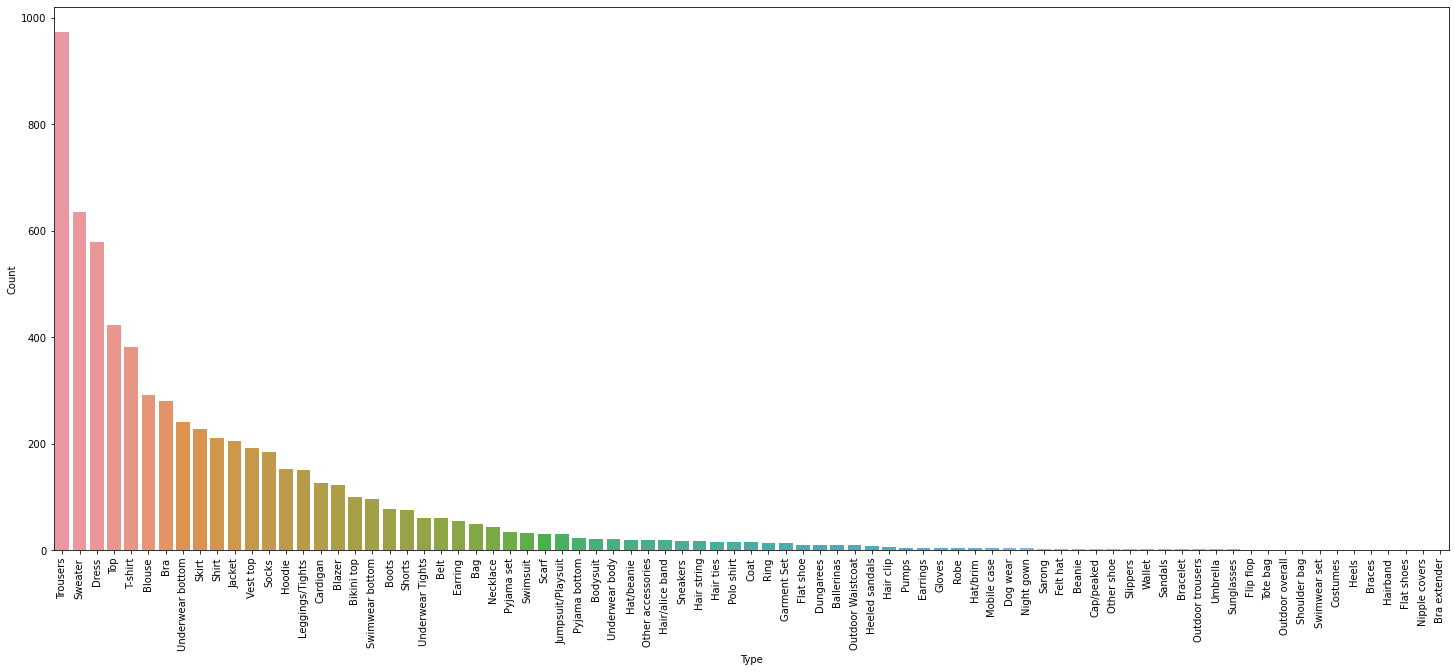

In [27]:
plt.figure(figsize=(25,10))
sns.barplot(x = 'Type', y = 'Count', data = type_df)
plt.xticks(rotation=90)
plt.show()

#### Product's Group Categorization

Following a similar process as above, let's compute the number of articles for each product's group, sorting them in order to have a better insight.

In [28]:
# Create Group Dataframe
group = Counter(articles_cln['product_group_name'])
group_df = pd.DataFrame([group]).T.reset_index()
group_df.columns = ['Group', 'Count']
group_df = group_df.sort_values(by='Count', ascending=False)
group_df


,Group,Count
3,Garment Upper body,2799
1,Garment Lower body,1428
6,Garment Full body,632
4,Underwear,547
5,Accessories,378
0,Socks & Tights,245
8,Swimwear,233
7,Shoes,135
9,Nightwear,60
2,Items,10


In [29]:
group_df.shape

(11, 2)

We can clearly see that this is a way more generic classificaiton (11 vs 81 rows) 

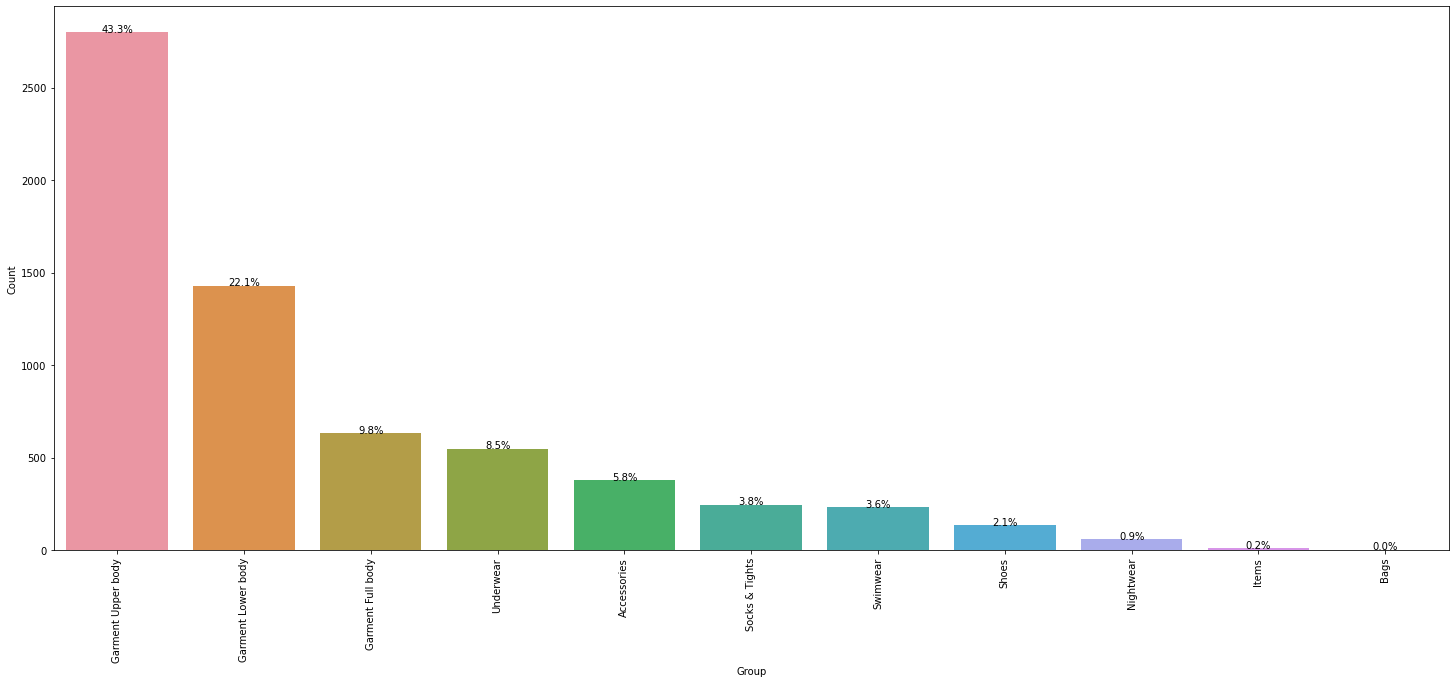

In [30]:
plt.figure(figsize=(25,10))
sns.barplot(x = 'Group', y = 'Count', data = group_df)
plt.xticks(rotation=90)

# Add the percentage values on top of the bar plot bars
for i, patch in enumerate(plt.gca().patches):
    height = patch.get_height()
    percentage = '{:.1f}%'.format(height / articles_cln.shape[0] * 100)
    plt.gca().text(patch.get_x() + patch.get_width() / 2, height + 1, percentage, ha='center')
    
plt.show()

#### Department

In [31]:
# Create Department dataframe
department = Counter(articles['department_name'])
department_df = pd.DataFrame([department]).T.reset_index()
department_df.columns = ['Department', 'Count']
department_df = department_df.sort_values( by ='Count', ascending=False)
department_df

,Department,Count
14,Jersey,400
41,Knitwear,339
29,Trouser,335
38,Blouse,307
8,Basic 1,262
...,...,...
88,Kids Girl Jersey Basic,1
93,Men Sport Bottoms,1
96,Kids Girl Denim,1
99,Kids Boy Jersey Basic,1


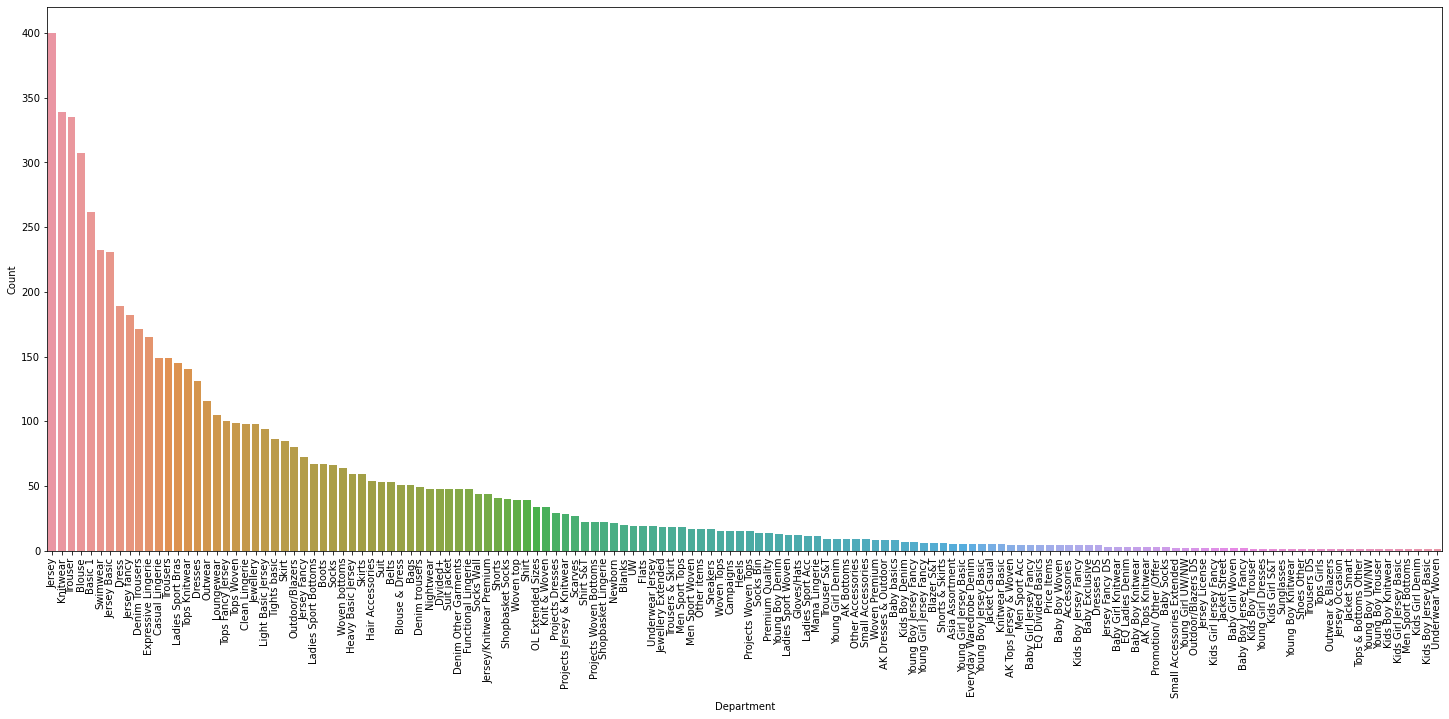

In [32]:
plt.figure(figsize=(25,10))
sns.barplot(x = 'Department', y = 'Count', data = department_df)
plt.xticks(rotation=90)

plt.show()

#### Index Group 

In [33]:
index_group = Counter(articles_cln['index_group_name'])
index_group_df = pd.DataFrame([index_group]).T.reset_index()
index_group_df.columns = ['Index Group', 'Count']
index_group_df = index_group_df.sort_values( by ='Count', ascending = False)
index_group_df

,Index Group,Count
0,Ladieswear,3983
2,Divided,1521
4,Menswear,571
1,Sport,270
3,Baby/Children,124


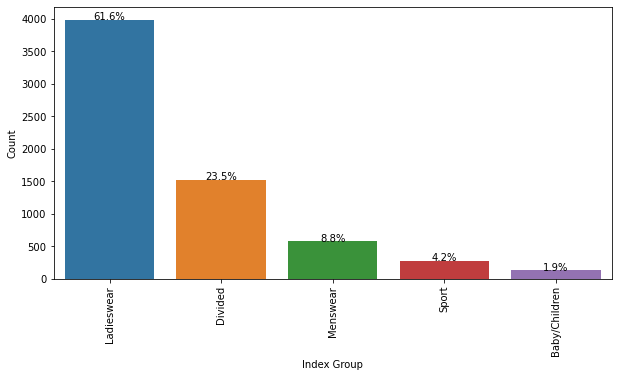

In [34]:
plt.figure(figsize=(10,5))
sns.barplot(x = 'Index Group', y = 'Count', data = index_group_df)
plt.xticks(rotation=90)

# Add the percentage values on top of the bar plot bars
for i, patch in enumerate(plt.gca().patches):
    height = patch.get_height()
    percentage = '{:.1f}%'.format(height / articles_cln.shape[0] * 100)
    plt.gca().text(patch.get_x() + patch.get_width() / 2, height + 1, percentage, ha='center')

plt.show()

#### Section

In [35]:
section = Counter(articles_cln['section_name'])
section_df = pd.DataFrame([section]).T.reset_index()
section_df.columns = ['Section', 'Count']
section_df = section_df.sort_values( by='Count', ascending=False)
section_df

,Section,Count
19,Womens Everyday Collection,880
22,Divided Collection,768
26,Womens Tailoring,517
3,Womens Lingerie,463
0,"Womens Nightwear, Socks & Tigh",339
6,Divided Basics,286
10,Men Underwear,254
11,Ladies Denim,244
4,Womens Everyday Basics,232
16,"Womens Swimwear, beachwear",231


In [36]:
section_df.shape

(43, 2)

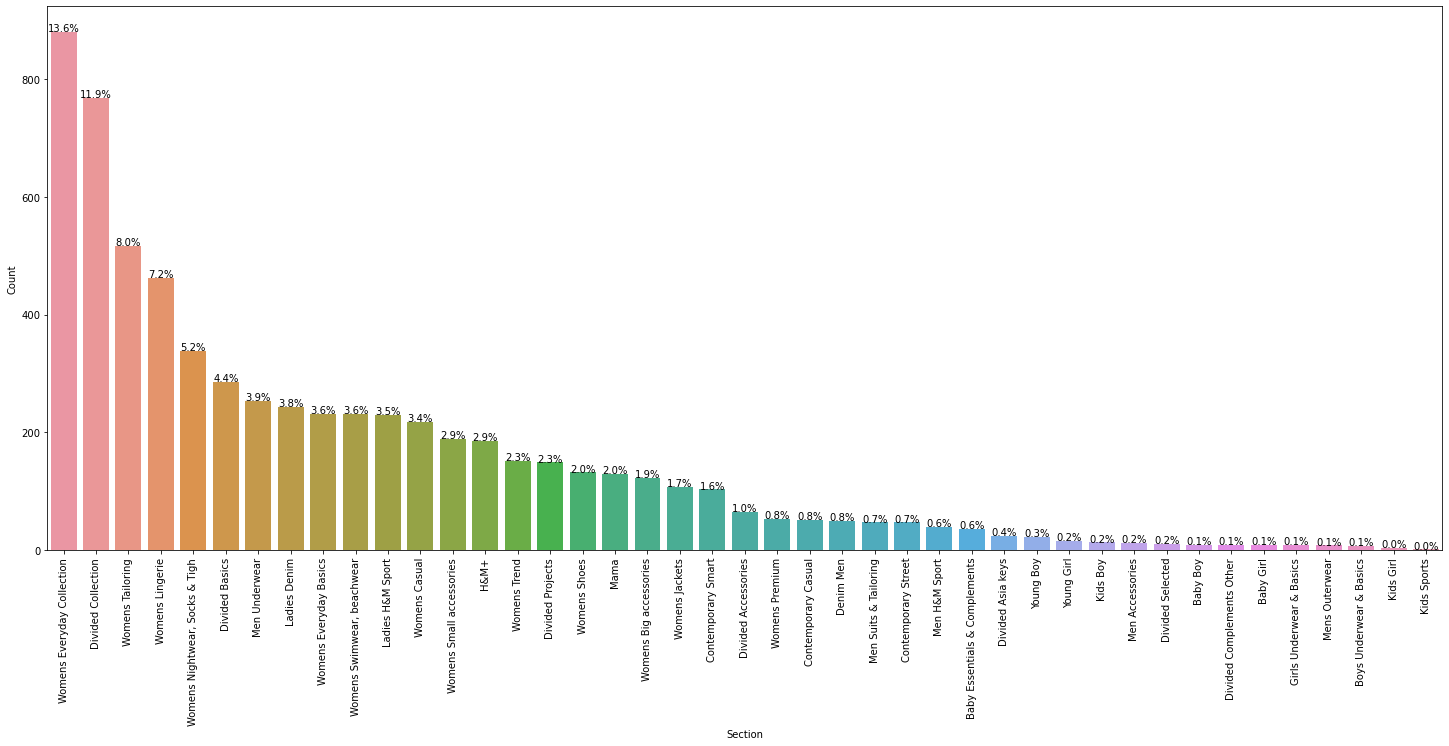

In [37]:
plt.figure(figsize=(25,10))
sns.barplot(x='Section', y='Count', data = section_df)
plt.xticks(rotation=90)
# Add the percentage values on top of the bar plot bars
for i, patch in enumerate(plt.gca().patches):
    height = patch.get_height()
    percentage = '{:.1f}%'.format(height / articles_cln.shape[0] * 100)
    plt.gca().text(patch.get_x() + patch.get_width() / 2, height + 1, percentage, ha='center')

plt.show()

#### Garment Group

In [38]:
garment_group = Counter(articles_cln['garment_group_name'])
garment_group_df = pd.DataFrame([garment_group]).T.reset_index()
garment_group_df.columns = ['Garment Group', 'Count']
garment_group_df = garment_group_df.sort_values(by='Count', ascending=False)
garment_group_df

,Garment Group,Count
2,Jersey Fancy,1063
4,Jersey Basic,692
3,"Under-, Nightwear",658
6,Trousers,603
12,Knitwear,536
11,Blouses,524
1,Accessories,403
13,Dresses Ladies,361
7,Trousers Denim,326
0,Socks and Tights,250


In [39]:
garment_group_df.shape

(21, 2)

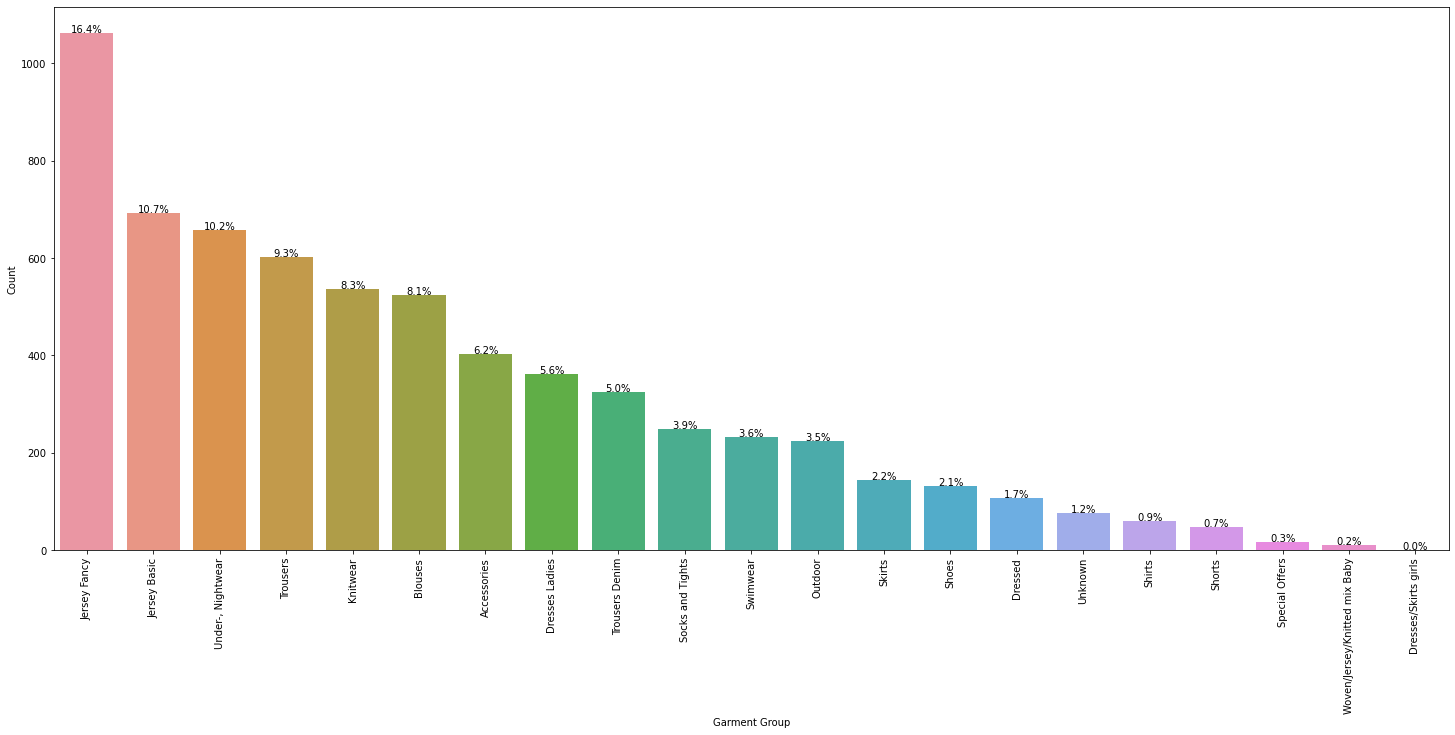

In [40]:
plt.figure(figsize=(25,10))
sns.barplot(x='Garment Group', y='Count', data = garment_group_df)
plt.xticks(rotation=90)

# Add the percentage values on top of the bar plot bars
for i, patch in enumerate(plt.gca().patches):
    height = patch.get_height()
    percentage = '{:.1f}%'.format(height / articles_cln.shape[0] * 100)
    plt.gca().text(patch.get_x() + patch.get_width() / 2, height + 1, percentage, ha='center')

plt.show()

#### Colour

As what regards colours, we have many different columns and so we have a pretty wide range of options to choose from. since there is no particular reason to analyse a specific column rather than another one, we will just print out the number of unique values for each colour column and pick the one that a number of unique values in the middle.

In [83]:
print(f"The number of unique values in column 'colour_group_name' is: {len(articles_cln['colour_group_name'].unique())}")
print(f"The number of unique values in column 'perceived_colour_value_name' is: {len(articles_cln['perceived_colour_value_name'].unique())}")
print(f"The number of unique values in column 'perceived_colour_master_name' is: {len(articles_cln['perceived_colour_master_name'].unique())}")

The number of unique values in column 'colour_group_name' is: 45
The number of unique values in column 'perceived_colour_value_name' is: 6
The number of unique values in column 'perceived_colour_master_name' is: 16


We see that the middle value correspond to the column perceived_colour_master_name, so this is the colour column we are going to analyse.

##### Colour Group

In [41]:
colour_group = Counter(articles_cln['colour_group_name'])
colour_group_df = pd.DataFrame([colour_group]).T.reset_index()
colour_group_df.columns = ['Colour Group', 'Count']
colour_group_df = colour_group_df.sort_values(by='Count', ascending=False)
colour_group_df

,Colour Group,Count
0,Black,2098
4,White,595
1,Dark Blue,327
5,Beige,319
3,Light Beige,303
9,Grey,232
16,Blue,225
27,Light Pink,210
2,Dark Grey,206
22,Off White,191


In [42]:
colour_group_df.shape

(46, 2)

A quick observation may be that this dataframe is a bit too broad, and this may induce model's overfitting.

##### Perceived Colour Value

In [43]:
perc_colour_val = Counter(articles_cln['perceived_colour_value_name'])
perc_colour_val_df = pd.DataFrame([perc_colour_val]).T.reset_index()
perc_colour_val_df.columns = ['Perceived Colour Value', 'Count']
perc_colour_val_df = perc_colour_val_df.sort_values(by='Count', ascending=False)
perc_colour_val_df

,Perceived Colour Value,Count
0,Dark,2925
1,Dusty Light,1401
3,Medium Dusty,1000
2,Light,807
5,Bright,211
4,Medium,120
6,Undefined,5


In [44]:
perc_colour_val_df.shape

(7, 2)

Contrary to before, this dataframe is probably too small, since it has only 7 values' category whithin it.

##### Perceived Colour Master

In [45]:

perc_colour_master = Counter(articles_cln['perceived_colour_master_name'])
perc_colour_master_df = pd.DataFrame([perc_colour_master]).T.reset_index()
perc_colour_master_df.columns = ['Colour', 'Count']
perc_colour_master_df = perc_colour_master_df.sort_values(by='Colour')
perc_colour_master_df

,Colour,Count
3,Beige,540
0,Black,2111
1,Blue,717
5,Brown,150
15,Green,176
2,Grey,519
7,Khaki green,218
10,Lilac Purple,108
9,Metal,116
6,Mole,176


In [46]:
perc_colour_master_df.shape

(18, 2)

Finally, this dataframe seems to be a middle ground between the previous two. It has, indeed, 18 values' category, which seem to be a pretty good number.

We notice that there are some undefined values, 5 in this dataframe...let's see how many there are of them.

In [47]:
# Count the number of "undefined" values in the entire dataset
undefined_count = articles_cln.isin(["undefined"]).sum(axis=1).sum()

Since there are very few undefined values, 5 if we want to be more specific, and they don't give us any relevant and useful information, we want to remove them.

In [48]:
# Remove rows with "undefined" values in any column
articles_cln = articles_cln[~articles_cln.isin(["undefined"]).any(axis=1)]


There are also some values encoded as "unknown" so we want to remove them too.

In [49]:
# Count the number of "undefined" values in the entire dataset
unknown_count = articles_cln.isin(["Unknown"]).sum(axis=1).sum()

# Print the count
print(unknown_count)

136


In [50]:
# Remove rows with "undefined" values in any column
articles_cln = articles_cln[~articles_cln.isin(["Unknown"]).any(axis=1)]


Let's check if our code run successfully:

In [51]:
# Count the number of "undefined" values in the entire dataset
undefined_count = articles_cln.isin(["Undefined"]).sum(axis=1).sum()

# Print the count
print(undefined_count)

0


In [52]:
# Count the number of "unknown" values in the entire dataset
unknown_count = articles_cln.isin(["Unknown"]).sum(axis=1).sum()

# Print the count
print(unknown_count)

0


In [53]:
perc_colour_master = Counter(articles_cln['perceived_colour_master_name'])
perc_colour_master_df = pd.DataFrame([perc_colour_master]).T.reset_index()
perc_colour_master_df.columns = ['Colour', 'Count']
perc_colour_master_df = perc_colour_master_df.sort_values(by='Count', ascending=False)
product_colour_df = perc_colour_master_df
product_colour_df

,Colour,Count
0,Black,2076
4,White,794
1,Blue,711
3,Beige,533
2,Grey,516
12,Pink,365
7,Khaki green,213
13,Green,176
6,Mole,171
14,Orange,158


Perfect, so now we have cleaned our dataset even more.

Let's move to display our colour dataframe.

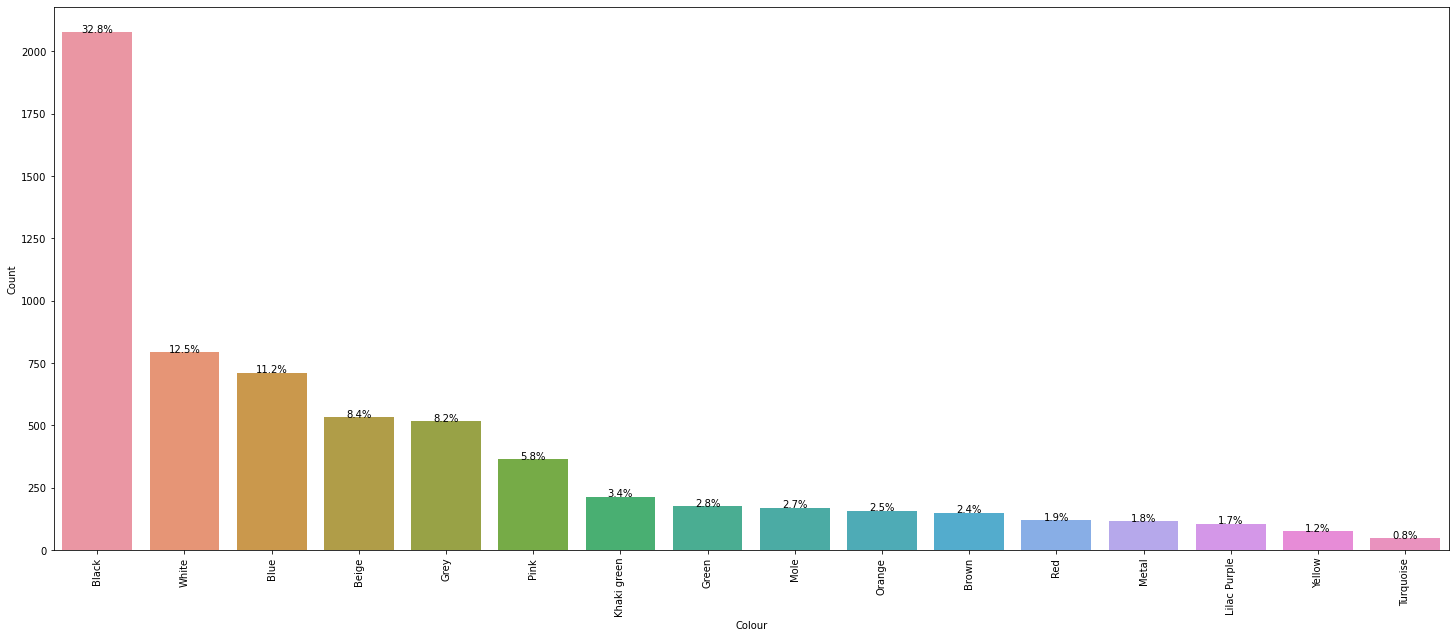

In [54]:
plt.figure(figsize=(25,10))
sns.barplot(x = 'Colour', y = 'Count', data = product_colour_df)
plt.xticks(rotation=90)

# Add the percentage values on top of the bar plot bars
for i, patch in enumerate(plt.gca().patches):
    height = patch.get_height()
    percentage = '{:.1f}%'.format(height / articles_cln.shape[0] * 100)
    plt.gca().text(patch.get_x() + patch.get_width() / 2, height + 1, percentage, ha='center')
    
plt.show()

We can clearly see that black is by far the most common product's colour in out dataset.

As last step, we will print the number of unique elements for each categorical column (except for the ones regarding colours, since we already dealt this topic with them) in order to better predict the importance that each column might have when writing the content-based algorithm.

In [57]:
print(f"The number of unique values in column 'prod_name' is: {len(articles_cln['prod_name'].unique())}")
print(f"The number of unique values in column 'product_type_name' is: {len(articles_cln['product_type_name'].unique())}")
print(f"The number of unique values in column 'product_group_name' is: {len(articles_cln['product_group_name'].unique())}")
print(f"The number of unique values in column 'department_name' is: {len(articles_cln['department_name'].unique())}")
print(f"The number of unique values in column 'index_name' is: {len(articles_cln['index_name'].unique())}")
print(f"The number of unique values in column 'index_group_name' is: {len(articles_cln['index_group_name'].unique())}")
print(f"The number of unique values in column 'section_name' is: {len(articles_cln['section_name'].unique())}")
print(f"The number of unique values in column 'garment_group_name' is: {len(articles_cln['garment_group_name'].unique())}")

The number of unique values in column 'prod_name' is: 3581
The number of unique values in column 'product_type_name' is: 80
The number of unique values in column 'product_group_name' is: 11
The number of unique values in column 'department_name' is: 138
The number of unique values in column 'index_name' is: 9
The number of unique values in column 'index_group_name' is: 5
The number of unique values in column 'section_name' is: 42
The number of unique values in column 'garment_group_name' is: 20


Now that our analysis on article's dataset is completed, we can move to the last, and probably most important, dataset.

## Transaction's Dataset EDA

In [60]:
# Let's start by analysing the transaction's dataset: first of all we import it and then we print a small insight of the dataset: 
transactions = pd.read_csv("recsys_transactions.csv")
transactions.head()

,t_dat,customer_id,article_id
0,2020-09-02,7,599
1,2020-09-02,7,2600
2,2020-09-02,7,2063
3,2020-09-02,7,5188
4,2020-09-02,17,5111


In [61]:
# Display dimension of the dataset
transactions.shape

(369113, 3)

This dataset is very compact: it has a very small number of columns, indeed it has only the strictly necessary information for the transaction itself, which are the customer's id, the article's id and the date when the transaction occurred. It has a very large amount of data stored (369113).

### Handling Null Values

As usual, the first thing to do is to check if there are any missing values or not.

In [62]:
transactions.isnull().sum()

t_dat          0
customer_id    0
article_id     0
dtype: int64

We could easily figure that result out: since this dataset is actually a relation between the customer and the article he/she purchased, if one value is null, the transaction can't take place.
One of the very last step we did in the previous dataset was to delete all articles  which were unknown and undefined. Now what we want is to filter the transaction dataset to only include transactions where the article's ID is present in the updated article dataset. So we can perform an inner join between the transaction dataset and the updated article dataset on the article's ID column. This will only keep rows in the transaction dataset that have a corresponding entry in the cleaned article dataset.

In [63]:
# Perform an inner join between the two dataframes on the article's ID column
transactions_cln = pd.merge(transactions, articles_cln, on='article_id', how='inner')

This dataframe only include rows from the transaction dataset that have a corresponding entry in the updated article dataset.


Let' see how the transaction dataset has changed:

In [64]:
print(len(transactions)-len(transactions_cln))

11578


We reduced the original dataset by 11578 columns.

Let's move on to the analysis of the dataset.

### Date Analysis

The first column that we have is the date column, so we want to extrapolate some useful information.
Just as we did for the article's dataset, let's visualize the dataframe of the date by plotting the bar chart.

We want to analyze data by grouping the transactions by date and counting the number of transactions. This can be useful for understanding overall customer activity and identifying trends over time.

In [65]:
date = Counter(transactions_cln['t_dat'])
date_df = pd.DataFrame([date]).T.reset_index()
date_df.columns = ['Date', 'Count']
date_df = date_df.sort_values(by='Date', ascending=False)
date_df

,Date,Count
20,2020-09-22,15401
19,2020-09-21,15537
18,2020-09-20,15597
17,2020-09-19,16532
16,2020-09-18,18361
15,2020-09-17,19711
14,2020-09-16,12911
13,2020-09-15,12763
12,2020-09-14,15094
11,2020-09-13,20514


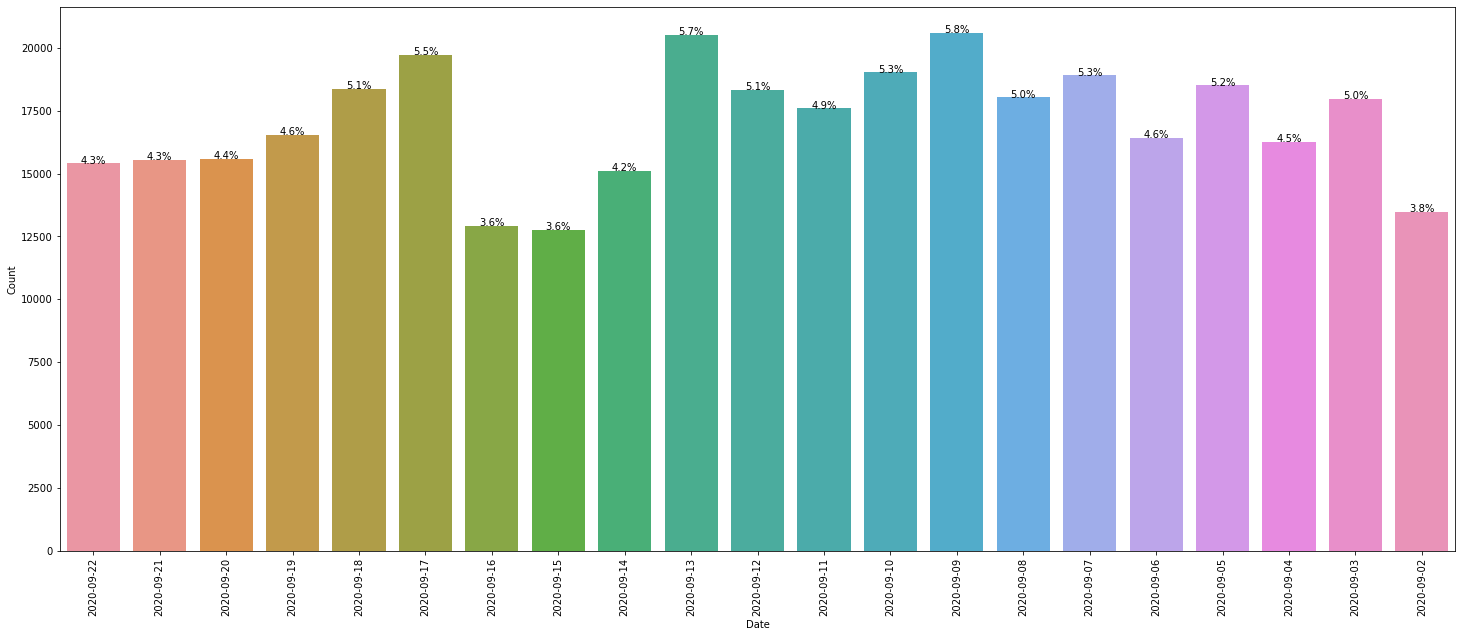

In [66]:
plt.figure(figsize=(25,10))
sns.barplot(x = 'Date', y = 'Count', data = date_df)
plt.xticks(rotation=90)

# Add the percentage values on top of the bar plot bars
for i, patch in enumerate(plt.gca().patches):
    height = patch.get_height()
    percentage = '{:.1f}%'.format(height / transactions_cln.shape[0] * 100)
    plt.gca().text(patch.get_x() + patch.get_width() / 2, height + 1, percentage, ha='center')
    
plt.show()

We can see that the distribution of the transaction's date is overall pretty uniform, having a peak in 2020-09-09 with exactly 20600 transactions.

Let's calculate the number of unique customers and articles involved in the transactions.

In [67]:
# Calculate the number of unique customers
num_unique_customers = transactions_cln['customer_id'].nunique()
print(f'The number of unique customers is: {num_unique_customers}')

# Calculate the number of unique articles
num_unique_articles = transactions_cln['article_id'].nunique()
print(f'The number of unique articles is: {num_unique_articles}')

The number of unique customers is: 41238
The number of unique articles is: 6328


### Global Analysis

It can be useful to calculate the number of transaction per customers (on average).

In [68]:
# Group the transactions by customer ID and count the number of transactions for each group
transactions_per_customer = transactions_cln.groupby('customer_id').size()

# Calculate the average number of transactions per customer
avg_transactions_per_customer = transactions_per_customer.mean()

print(f'The average number of transaction per customer is: {round(avg_transactions_per_customer)}')

The average number of transaction per customer is: 9


Let's create a dataframe containing customer id and number of transactions.

In [69]:
customer_transactions_count = Counter(transactions_cln['customer_id'])
customer_transactions_count_df = pd.DataFrame([customer_transactions_count]).T.reset_index()
customer_transactions_count_df.columns = ['Customer ID', 'Number of Transactions']
customer_transactions_count_df.sort_values(by='Number of Transactions', ascending=False).reset_index()


,index,Customer ID,Number of Transactions
0,34821,9197,99
1,732,36953,95
2,7974,16472,92
3,6695,13753,88
4,4960,33914,84
...,...,...,...
41233,41036,12686,1
41234,39402,13619,1
41235,34758,31681,1
41236,16139,17001,1


It can be extremely useful to compute the number of transaction for each item, since it can give us an idea of which items are the most popular and potentially make good recommendations.

In [70]:
# Group the transactions by item and count the number of transactions for each item
article_counts = transactions_cln.groupby('article_id').size().reset_index(name='num_transactions')

# Sort the items by the number of transactions
article_counts = article_counts.sort_values(by='num_transactions', ascending=False)

# Assign a ranking to each item based on its position in the sorted list
article_counts['ranking'] = range(1, len(article_counts) + 1)

# Display the resulting dataframe
print(article_counts)

      article_id  num_transactions  ranking
1380        1419              1045        1
165          168               896        2
5642        5831               889        3
5969        6166               858        4
1390        1429               815        5
...          ...               ...      ...
1198        1232                11     6324
2596        2670                11     6325
1202        1236                11     6326
3227        3322                11     6327
5489        5669                11     6328

[6328 rows x 3 columns]


Let's see the article's names, merging the transactions and cleaned articles dataset, adding the prod_name column from the articles dataset to the transactions dataset and renaming it to article_name. 

In [71]:
# Merge the item_counts and articles data using the item_id column as the key
merged_name_df = pd.merge(article_counts, articles_cln, on='article_id')

# Rename the prod_name and product_type_name columns
merged_name_df = merged_name_df.rename(columns={"prod_name": "article_name"})

# Group the data by article_name and sum the num_transactions column
name_df = merged_name_df.groupby('article_name')['num_transactions'].sum().reset_index()

# Sort the rows in the summed_df dataframe by num_transactions in descending order
name_df = name_df.sort_values(by='num_transactions', ascending=False)

# Assign a ranking to each item based on its position in the sorted list
name_df['ranking'] = range(1, len(name_df) + 1)

# Display the resulting dataframe
print(name_df)



                     article_name  num_transactions  ranking
2620          Pluto RW slacks (1)              3508        1
1559     Jade HW Skinny Denim TRS              3292        2
1933                  Lucy blouse              3243        3
1930             Lucien CONSCIOUS              2076        4
1857                      Liliana              1847        5
...                           ...               ...      ...
370   Beach Please Super Push Bra                11     3577
817                   Dane trench                11     3578
377              Becky Bucket Hat                11     3579
3104            Sorrento cardigan                11     3580
3580               zelda leggings                11     3581

[3581 rows x 3 columns]


#### Top 20 article's names

BARPLOT

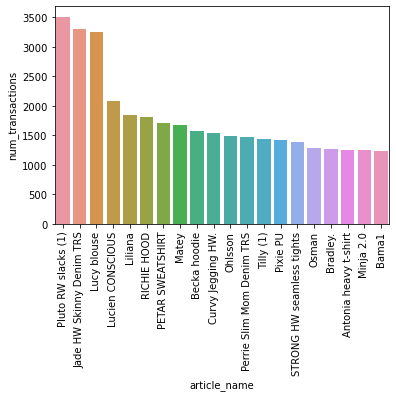

In [72]:
top_20_names = name_df.iloc[:20,:]

# Create a barplot using Seaborn
sns.barplot(x='article_name', y='num_transactions', data=top_20_names)
plt.xticks(rotation=90)

# Show the plot
plt.show()

#### Top 20 article's types

In [73]:
# Merge the item_counts and articles data using the item_id column as the key
merged_type_df = pd.merge(article_counts, articles_cln, on='article_id')

# Rename the prod_name and product_type_name columns
merged_type_df = merged_type_df.rename(columns={"product_type_name": "article_type_name"})

# Group the data by product_type_name and sum the num_transactions column
type_df = merged_type_df.groupby('article_type_name')['num_transactions'].sum().reset_index()

# Sort the rows in the summed_df dataframe by num_transactions in descending order
type_df = type_df.sort_values(by='num_transactions', ascending=False)

# Assign a ranking to each item based on its position in the sorted list
type_df['ranking'] = range(1, len(type_df) + 1)

# Display the resulting dataframe
print(type_df)



   article_type_name  num_transactions  ranking
73          Trousers             64282        1
66           Sweater             48881        2
71               Top             28194        3
18             Dress             25496        4
70           T-shirt             20658        5
..               ...               ...      ...
10      Bra extender                16       76
12            Braces                15       77
25         Flip flop                14       78
36             Heels                13       79
32          Hairband                13       80

[80 rows x 3 columns]


BARPLOT

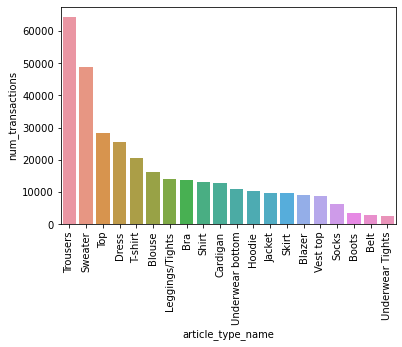

In [74]:
top_20_types = type_df.iloc[:20,:]

# Create a barplot using Seaborn
sns.barplot(x='article_type_name', y='num_transactions', data=top_20_types)
plt.xticks(rotation=90)

# Show the plot
plt.show()

#### Top 20 section's names

In [75]:
# Merge the item_counts and articles data using the item_id column as the key
merged_section_df = pd.merge(article_counts, articles_cln, on='article_id')

# Drop the item_id column and all other columns except for num_transactions, ranking, article_type.
merged_section_df = merged_section_df[["num_transactions", "section_name"]]

# Group the data by product_type_name and sum the num_transactions column
section_df = merged_section_df.groupby('section_name')['num_transactions'].sum().reset_index()

# Sort the rows in the summed_df dataframe by num_transactions in descending order
section_df = section_df.sort_values(by='num_transactions', ascending=False)

# Assign a ranking to each item based on its position in the sorted list
section_df['ranking'] = range(1, len(section_df) + 1)

# Display the resulting dataframe
print(section_df)

                      section_name  num_transactions  ranking
30      Womens Everyday Collection             76973        1
11              Divided Collection             47583        2
38                Womens Tailoring             31638        3
33  Womens Nightwear, Socks & Tigh             23415        4
32                 Womens Lingerie             20868        5
10                  Divided Basics             20753        6
29          Womens Everyday Basics             19086        7
20                Ladies H&M Sport             18324        8
19                    Ladies Denim             14743        9
28                   Womens Casual             11649       10
25                   Men Underwear             10404       11
16                            H&M+              8269       12
31                  Womens Jackets              6657       13
37      Womens Swimwear, beachwear              5552       14
39                    Womens Trend              4954       15
35      

BARPLOT

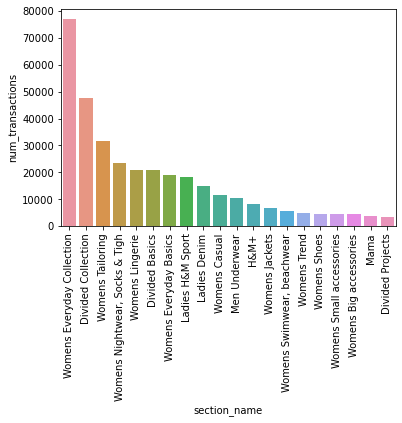

In [76]:
top_20_section = section_df.iloc[:20,:]

# Create a barplot using Seaborn
sns.barplot(x='section_name', y='num_transactions', data=top_20_section)
plt.xticks(rotation=90)

# Show the plot
plt.show()

# Content-based recommendation

A content-based recommendation system works by identifying the characteristics of the items in the store and using that information to recommend similar items to customers. To develop a content-based recommendation system, we should develop a similarity measure, such as cosine similarity, to determine how closely two items match each other based on their characteristics.

What we want to do, is to create a new dataframe where the values in a particular column from “articles_cln”, are stored such that each unique value is represented as a separate binary feature, where a value of 1 indicates that the row (a specific article) has that characteristic and a value of 0 indicates that it does not.

Below, we will write a few lines of code to create the binary dataframe with the values contained in the column 'product_type_name'... We count the number of occurrences of each value in the product_type_name column and we sotre them into a variable. We then define a list of all the unique values in the column and then we create the dataframe...

In [79]:
# we count the number of occurrences of each value in the column
product_type_name_count = articles_cln['product_type_name'].value_counts()

# We get a list of the unique values in the column...
product_type_name = list(product_type_name_count.keys())

# ...and for each value we create a new column in the dataframe
for s in product_type_name:
    articles_cln[s] = articles_cln['product_type_name'].transform(lambda x: int(s in x))
articles_cln[product_type_name]

,Trousers,Sweater,Dress,Top,T-shirt,Blouse,Bra,Underwear bottom,Skirt,Shirt,...,Hairband,Swimwear set,Heels,Braces,Outdoor overall,Bra extender,Nipple covers,Flat shoes,Tote bag,Shoulder bag
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6531,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6532,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6533,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


...we obviously do not want to create manually the dataframe for each column and then merge them all together. So, we write a simple function that takes as input the dataframe "articles_cln" and a list of column from the input dataframe and thanks to a loop, it iteratively merges the datframes it creates.

In [99]:
def binary_dataframe(dataframe, columns):
    final_binary_dataframe = pd.DataFrame()
    
    for column in columns:
        # we count the number of occurrences of each value in the column
        column_count = dataframe[column].value_counts()

        # We get a list of the unique values in the column...
        values = list(column_count.keys())

        # ...and for each value we create a new column in the dataframe
        for value in values:
            dataframe[value] = dataframe[column].transform(lambda x: int(value in x))
        
        # and then we merge in each iteration the dataframe just created
        final_binary_dataframe = pd.concat([final_binary_dataframe, dataframe[values]], axis=1)

    
    return final_binary_dataframe


columns = ['product_type_name', 'colour_group_name', 'perceived_colour_master_name', 'department_name', 'section_name', 'garment_group_name']
binary_dataframe = binary_dataframe(articles_cln, columns)
binary_dataframe

,Trousers,Sweater,Dress,Top,T-shirt,Blouse,Bra,Underwear bottom,Skirt,Shirt,...,Swimwear,Outdoor,Skirts,Shoes,Dressed,Shirts,Shorts,Special Offers,Woven/Jersey/Knitted mix Baby,Dresses/Skirts girls
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6531,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6532,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6533,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The function we will now write, first selects the row in the binary_dataframe that corresponds to the article ID. Then it computes the similarity between this row and all the other rows in binary_dataframe using cosine similarity. The function then selects the ten most similar articles based on their similarity scores, and prints a list of their product names and ID numbers. We will also add a check to ensure that the input article is not included in the list of recommended articles.

In [98]:
from sklearn.metrics.pairwise import cosine_similarity

# The function takes as input an article ID and the number of recommendation we want and returns a list of similar articles
def recommend_articles(article_id, num_recommendations):
    # It selects the article row
    article_row = binary_dataframe.iloc[article_id]
    
    # It computes the similarity between the article we are interested in and all other articles
    similarity = cosine_similarity([article_row], binary_dataframe)[0]
    similarity = pd.DataFrame(similarity)
    
    # It select the "num_recommendations" we want and stores them into a list...
    most_similar_articles = similarity[0].nlargest(num_recommendations).index.tolist()
    
    # ...and check that the input article is not in the list. If so, it selects a recommendation more than before and
    # deletes our input article from it. 
    if article_id in most_similar_articles:
        most_similar_articles = similarity[0].nlargest(num_recommendations+1).index.tolist()
        most_similar_articles.remove(article_id)
    
    # Eventually it iterates over the list and for each ID, it prints out name of the article and the ID.
    i = 1
    print(f"The most recommended articles are:")
    for row in most_similar_articles:
        
        prod_name = articles_cln.loc[row, 'prod_name']
        article_id = articles_cln.loc[row, 'article_id']
        print(f"{i}. {prod_name} - id number: {article_id}")
        i = i+1
    


article_id = 0
num_recommendations = 10
recommend_articles(article_id, num_recommendations)

The most recommended articles are:
1. Support 40 den 1p Tights - id number: 2
2. 200 den 1p Tights - id number: 3
3. Box 4p Kneehighs - id number: 15
4. Fleece leggings 1 p - id number: 35
5. 40 den 2p Tights - id number: 36
6. 30p pins - id number: 45
7. Astaire 1p Overknee - id number: 49
8. Theron (1) - id number: 58
9. Straight Edge 5p Socks - id number: 61
10. Small dot 1p Tights - id number: 77


# User-based collaborative filtering

In [100]:
# Create a matrix of users and items, with the ratings or interactions between them
ratings_matrix = transactions_cln.pivot_table(index='customer_id', columns='article_id', values='t_dat', aggfunc='count')
# Fill in missing values with 0
ratings_matrix.fillna(0, inplace=True)

In [101]:
# Select only the users that have rated a sufficient number of items
min_rated_items = 10  # minimum number of rated items
user_counts = ratings_matrix.apply(np.count_nonzero, axis=1)  # count of rated items for each user
ratings_matrix = ratings_matrix.loc[user_counts >= min_rated_items]  # select users with sufficient ratings

In [102]:
# Calculate the similarity matrix
similarity_matrix = np.corrcoef(ratings_matrix)
print(similarity_matrix)

[[ 1.         -0.00205515 -0.00200303 ... -0.00184934 -0.0020903
   0.07013425]
 [-0.00205515  1.         -0.00162397 ... -0.00149936 -0.00169472
  -0.00177925]
 [-0.00200303 -0.00162397  1.         ... -0.00146134 -0.00165174
  -0.00173412]
 ...
 [-0.00184934 -0.00149936 -0.00146134 ...  1.          0.1516538
  -0.00160107]
 [-0.0020903  -0.00169472 -0.00165174 ...  0.1516538   1.
  -0.00180968]
 [ 0.07013425 -0.00177925 -0.00173412 ... -0.00160107 -0.00180968
   1.        ]]


In [103]:
# For each user, retrieve the k most similar users
k = 10  # number of similar users to retrieve
user_id = 39  # target user
similar_users = np.argpartition(similarity_matrix[user_id], -k)[-k:]
print(similar_users)

[1737 3021 5766 4515 2266  367 6010   39 6319 6271]


In [104]:
# For each item that the user has not rated, predict the rating
predicted_ratings = []
for item_id in ratings_matrix.columns:  # loop through the items in the dataframe
    if ratings_matrix.loc[user_id][item_id] == 0:  # if the user has not rated the item
        ratings = []
        for similar_user in similar_users:
            if similar_user not in ratings_matrix.index:  # if the user does not exist in the dataframe
                continue  # skip to the next user
            ratings.append(ratings_matrix.loc[similar_user][item_id])
        predicted_rating = np.mean(ratings)
        predicted_ratings.append((item_id, predicted_rating))

# Recommend the items with the highest predicted ratings to the user
recommended_items = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)

recommended_items_cl=[]
for x in recommended_items:
    if x[1]!= 0.0:
        recommended_items_cl.append(x)

print("Dear user "+str(user_id)+", there are other products that could be interesting for you:")  
for y in recommended_items_cl:
    print('article number '+str(y[0]))

Dear user 39, there are other products that could be interesting for you:
article number 277
article number 278
article number 548
article number 579
article number 582
article number 1144
article number 1145
article number 1148
article number 1151
article number 1511
article number 1677
article number 2095
article number 2202
article number 2206
article number 2249
article number 2251
article number 2448
article number 2693
article number 2903
article number 2970
